# **Ice Flow Mini Project**
# Force Balance Along the Bindschadler and MacAyeal Ice Streams   

In this project, you will use observational data sets to estimate and interpret the balance of forces controlling flow on the Bindschadler (BIS) and MacAyeal (MAIS) Ice Streams in West Antarctica. These fast flowing regions drain ice from central West Antarctica onto the Ross Ice Shelf along the Siple Coast. A map of the region, with ice velocity overlain on surface topography, is shown below.    

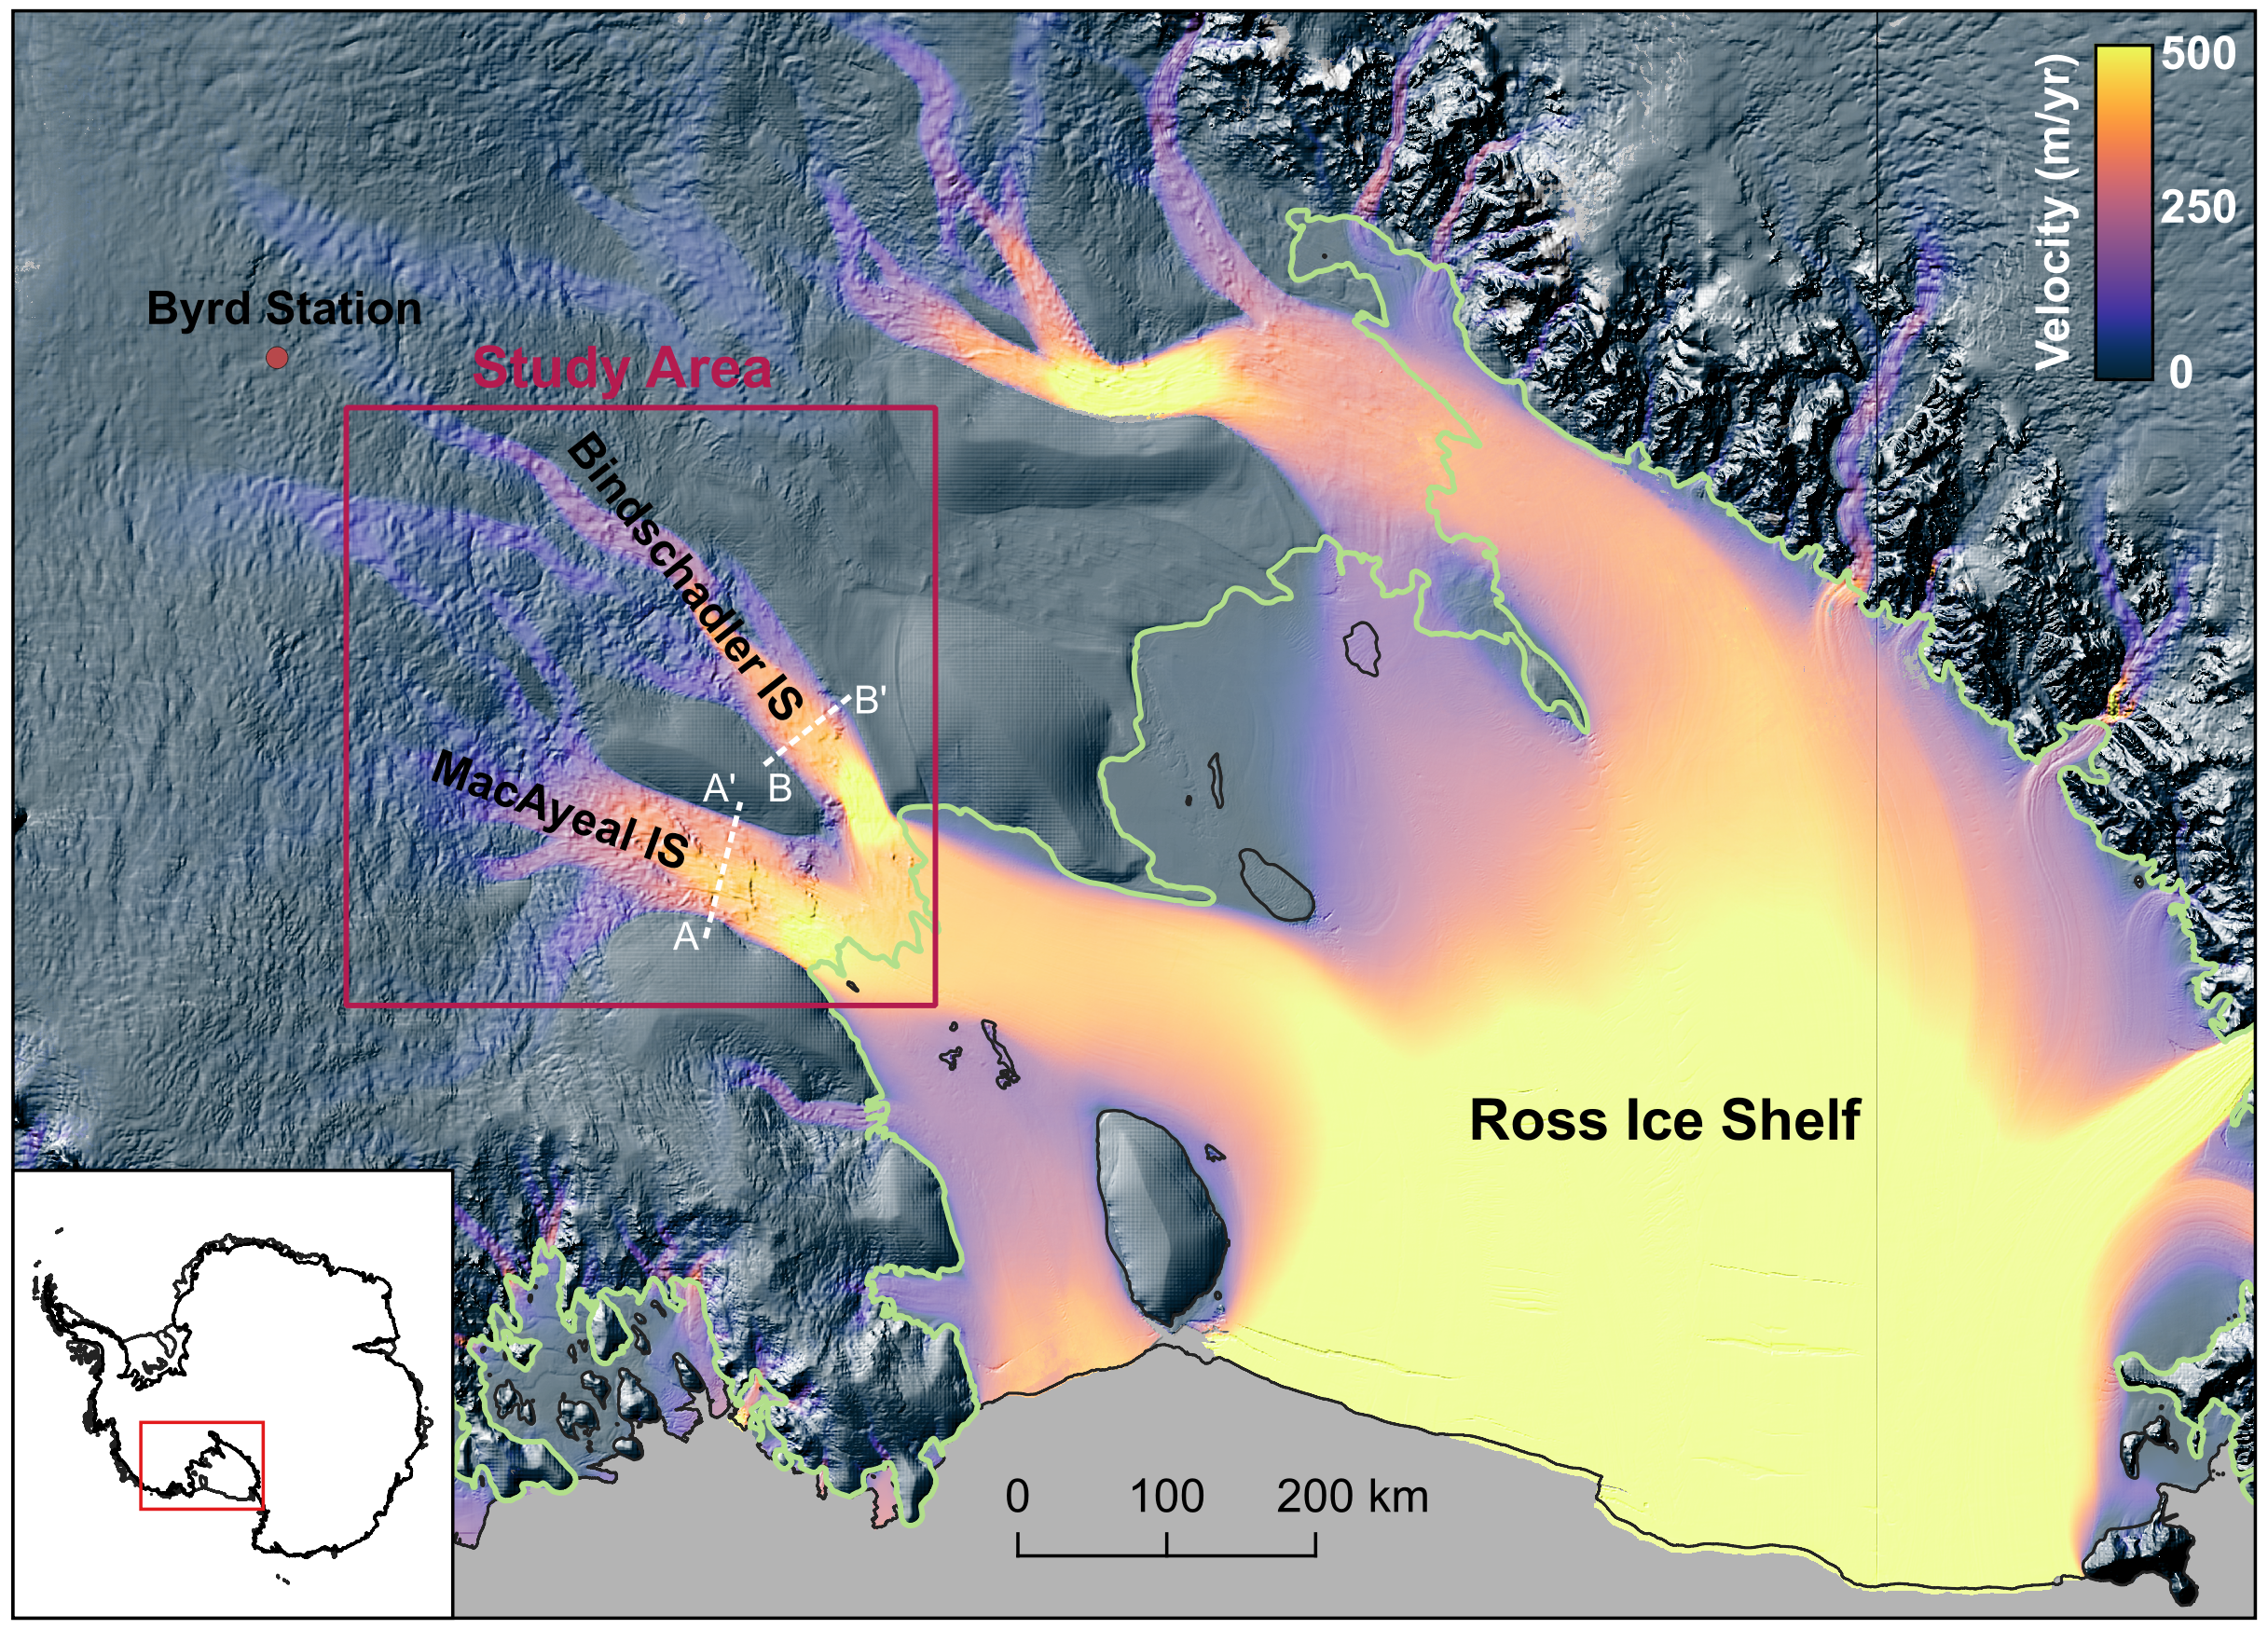

## Part 1: Methods and Assumptions  

The datasets that you have to work with are:   
(1) Surface velocities derived from interferometric synthetic aperture radar satellite observations.   
(2) Ice surface elevation derived from laser and radar altimetry.   
(3) Ice bed elevation derived from ice penetrating radar and mass conservation assumptions.   
(4) Firn air content derived from a regional climate model.   
These products are all provided on a regular grid with 2 km spacing over the study area shown on the map above.

**Part 1a:** Before you start coding, outline a workflow for estimating the force balance in each grid cell. Key points you should address include:

(1) What are the key assumptions required to make it tractable to apply this force balance method?   

(2) Given these assumptions, what are the equation(s) for the force balance?   


(3) How will you get from the provided data products to the variables in the force balance equation(s)?     

## Part 2: Setting Up the Computing Environment  

Run the codes below to set up your computing environment.

We start by importing the `rasterio` package which we will use to the load the GeoTIFF files that store gridded information about the velocity, surface elevation, and bed elevation. We also need to mount our Google Drive so that we can access the data files. Make sure that you have saved all of the data files provided through Canvas to the Google drive associated with the account you use for Google Colab in a directory structure called /EAS4940/IceFlowProject. Finally, we can import the libraries we will use for the rest of this project. Collectively, these commands may take a few minutes to run.

In [ ]:
!pip install rasterio
from google.colab import drive
drive.mount('/content/drive')

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as snd
import pandas as pd

## Part 3: Checking Assumptions  

One of the ways that we can check the applicability of our assumptions from Part 1 is to compare the shape of the ice stream surface velocity profiles with the analytical solution from the SSA that we derived in class. The code below loads two velocity profiles taken along the transects A-A' and B-B' shown in Figure 1. These profiles give the ice velocity component in the direction of ice flow in meters per year along a slice perpendicular to ice flow (e.g. the "y" direction).

In [ ]:
# Import the contents of the csv file into a pandas data frame
# Similar to a dictionary, use the keys above to retrieve numpy arrays for each variable
# For example bis['Velocity'] will give you a numpy array of velocity values along the transect
# bis['Distance'] will give you the distance in meters along the transect
bis = pd.read_csv('/content/drive/MyDrive/EAS4940/IceFlowProject/BISVelocityProfile.csv', sep=',', header=0)     # Bindschadler Ice Stream
mais = pd.read_csv('/content/drive/MyDrive/EAS4940/IceFlowProject/MAISVelocityProfile.csv', sep=',', header=0)   # MacAyeal Ice Stream

**Part 3a:** Plot the SSA analytical solution for the velocity profile on an ice stream in the y direction and compare this solution to the the measured velocity profiles. You can assume the following values:

Depth-averaged temperature: -22 C   
Ice thickness (BIS): 930 m    
Surface slope (BIS): 0.1 degrees    
Ice thickness (MAIS): 1060 m    
Surface slope (MAIS): 0.3 degrees    

For each profile, choose a value of $\tau^*$ that optimizes the fit to the measured velocity profile.   

Then anwer the following questions:  

(1) How do the modeled and measured velocities compare?    

(2) What might be some plausible explanations for discrepancies between the measured and modeled velocities?   

(3) What values of $\tau^*$ did you choose? What might this suggest about differences in basal conditions between the two ice streams?  

(4) Do these results suggest that your assumptions from Part 1 can reasonably be applied to the flow of these ice streams? Why or why not?   

## Part 4: Data Preparation

Now we can load the rest of our data and start the force balance calculations. A few important notes about the data:    

(1) Velocity is measured in meters per year.  
(2) Positive x velocities are flowing from left to right in the arrays, and positive y velocities are flowing from bottom to top in the arrays.    
(3) Surface and bed elevation are measured in meters relative to the WGS84 ellipsoid.  
(4) Firn air content is measured in meters.    
(5) The spatial resolution of the data sets is 500 m x 500 m.

In [ ]:
# Load datasets
dataset_x = rasterio.open('/content/drive/MyDrive/EAS4940/IceFlowProject/Vx_IceStreams.tif')
dataset_y = rasterio.open('/content/drive/MyDrive/EAS4940/IceFlowProject/Vy_IceStreams.tif')
dataset_surf = rasterio.open('/content/drive/MyDrive/EAS4940/IceFlowProject/Surface_IceStreams.tif')
dataset_bed = rasterio.open('/content/drive/MyDrive/EAS4940/IceFlowProject/Bed_IceStreams.tif')
dataset_fac= rasterio.open('/content/drive/MyDrive/EAS4940/IceFlowProject/FAC_IceStreams.tif')

# Extract the first band from each image
vx = dataset_x.read(1)   # X component of velocity
vy = dataset_y.read(1)   # Y component of velocity
surface = dataset_surf.read(1)  # surface elevation
bed = dataset_bed.read(1)       # bed elevation
fac = dataset_fac.read(1)       # firn air content

We typically need to smooth or average datasets before estimating stresses to reduce the impact of noise in the data and so that our computations are done at scales that are relevant for ice flow. This is particularly important when estimating the driving stress. To gain a better understanding of why, read Sections 8.7.2 from Cuffey & Patterson.

**Part 4a:** Then answer the following questions:   

(1) What controls the "longitudinal coupling length"? What is meant by that term and how does it impact our data analysis?  

(2) The surface elevation data set you have been provided has been smoothed using a triangular filter with a width of 10km, then resampled to a regular 2km grid. How does this compare to the approximate longitudinal coupling length for ice sheets?  

## Part 5: Calculate Strain Rates from Surface Velocities

**Part 5a:** Using the loaded velocity data, write your own code to calculate the components of the strain tensor at the surface. Plot your results.
Hint: make sure you define a consistent direction for your x and y axes.

These strain rates are calculated in an arbitrary x-y coordinate system aligned with the edges of the image. However, it would be much more useful to visualize the strain rate in a coordinate system that is tied to the ice flow direction. This is analagous to how, in class, we typically define our coordinate system so that x points along the direction of glacier flow and y is across flow. We will call these three strain tensor components the longitudinal strain (along the direction of flow), the transverse strain (perpendicular to flow), and shear strain (off-axis from flow).   

**Part 5b:** Calculate the ice flow direction at every point in the image and plot the results.

**Part 5c:** Now knowing the flow direction, apply a tensor rotation to calculate the longitudinal, transverse, and shear strain components.   
Hint: Read Alley, et al (2018) "Continent-wide estimates of Antarctic strain rates from Landsat 8-derived velocity grids" or van der Veen, Section 1.2.

**Part 5d:** Answer the following questions.
  
(1) Describe how the longitudinal strain rate varies along the length of each cie stream. What does this mean physically (extension, compression, etc)? What physical mechanism(s) do you think might be responsible for this variation?    

(2) What happens to the transverse strain rates where the two ice streams converge near the bottom right corner of our area of interest? Give a possible explanation for this behavior.   

(3) You should see distinctive bands of high and low shear strain rates outlining the edges of the ice streams. Why (physically) do you think this happens? (Hint: look at the changes in velocity in those regions)   

**Part 5e:** Calculate and plot a map of the effective strain rate. Then answer the following question.   

(1) Does it matter which coordinate system you use when calculating the effective strain? Why or why not?

## Part 6: Calculate Stresses from Strain Rates

We can now use our understanding of ice rheology to calculate the surface stresses from the surface strain rates.

**Part 6a:** Build on the import code below to calculate the depth averaged englacial temperature from the Byrd Station borehole temperature profile.

In [ ]:
import pandas as pd

# Import the contents of the csv file into a pandas data frame
# Similar to a dictionary, use the keys above to retrieve numpy arrays for each variable
# For example data['thickness'] will give you a numpy array of glacier thicknesses
data = pd.read_csv('/content/drive/MyDrive/EAS4940/IceFlowProject/ByrdTemperatureProfile.csv', sep=',', header=0)

For simplicity, we are using a constant, depth-averaged temperature across the entire domain to estimate the ice rheology.

**Part 6b:** Answer the following questions:

(1) Why might this be a poor choice?    

(2) Are there certain regions where this might be a particularly bad choice? Why?  

**Part 6c:** Calculate the deviatoric surface stresses using your englacial temperature and surface strain rates. Plot the deviatoric stresses. (Hint: make sure your units are consistent across all data sources and physical constants!)

## Part 7: Calculate the Driving Stress

**Part 7a:** Use the provided data sets to calculate the driving stress in the direction of ice flow. You may assume that the influence of bed slope is neglible. Then answer the following question.  

(1) You many notice that the driving stress is slightly negative in some regions. What does this tell us abou the discrepancies between the direction of ice flow and the direction of maximum surface slope?

## Part 8: Force Balance   

Now let's use this information to calculate an approximate force balance for our region of interest.

**Part 8a:** Using the assumptions you developed in Part 1, calculate the longitudal coupling stress, wall drag, and basal shear stress in the direction of ice flow. Plot your results.

**Part 8b:** Mask out regions flowing slower than 50 m/yr (regions outside the ice streams) and plot the basal shear stress only in the fast flowing regions. Then use your plots to answer the question below.  

(1) Why should we mask out regions with slow flowing ice before making interpretations?   

(2) What is the general magnitude of the longitudinal coupling and wall drag stresses relative to the basal shear stress? What does this tell you about the primary mechanism of flow resistance?     

(3) Is the basal shear stress field smooth or highly variable? What might this tell you about the character of the ice sheet bed under these ice streams? What processes might lead to the variations (or lack thereof) that you observe?  

(4) Compare your results to Figure 14 in Joughin et al. (2004) "Basal shear stress of the Ross ice streams from control method inversions," Journal of Geophysical Research. doi: 10.1029/2003JB002960. Ice Stream D is the Bindschalder Ice Stream and Ice Stream E is the MacAyeal Ice Stream. What might explain some of the differences between your results and the results in this paper?  

## Conclusions:  

Use the code below to export your completed notebook to a pdf file for submission. This may take some time!

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

!cp "/content/drive/MyDrive/Github/glaciology_assignments/Proj1_ForceBalance.ipynb" ./

!jupyter nbconvert --to PDF "Proj1_ForceBalance.ipynb"